In [ ]:
from huggingface_hub import login

login(token="**********************")

In [2]:
!pip install -q unsloth==2025.4.7 datasets==3.5.1

In [3]:
import torch
from trl import SFTTrainer
from datasets import load_dataset
from unsloth import FastLanguageModel
from transformers import GenerationConfig
from transformers import TrainingArguments

<ipython-input-3-d8ca6e03aa26>:4: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
MAX_SEQ_LENGTH = 2048
base_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    max_seq_length=MAX_SEQ_LENGTH,
    load_in_4bit=True,
    dtype=torch.bfloat16,
)

==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Device does not support bfloat16. Will change to float16.


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

In [5]:
model = FastLanguageModel.get_peft_model(
    base_model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "up_proj",
        "down_proj", "o_proj", "gate_proj"
    ],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state=42,
)

Unsloth 2025.4.7 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


In [8]:
dataset_name = "5CD-AI/Vietnamese-Multi-turn-Chat-Alpaca"
raw_dataset = load_dataset(dataset_name, split="train")

README.md:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

vi_chatalpaca_cleaned.json:   0%|          | 0.00/69.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12697 [00:00<?, ? examples/s]

In [ ]:

for i, example in enumerate(raw_dataset):
    print(f"Row {i}:")
    print(f"ID: {example['id']}")
    print(f"Conversations: {example['conversations']}")
    print("-" * 50)
    if i >= 9:  
        print("Stopped after 10 rows. Remove this limit to see all.")
        break

Row 0:
ID: 19217
Conversations: [{'from': 'human', 'value': 'Hãy chỉnh sửa câu này để ngắn gọn hơn mà không mất đi ý nghĩa: "Trận đấu là một thất bại nặng nề mặc dù thực tế là cả đội đã tập luyện trong nhiều tuần."'}, {'from': 'gpt', 'value': 'Nhiều tuần huấn luyện của đội đã dẫn đến một thất bại nặng nề.'}, {'from': 'human', 'value': 'Bạn có thể đề xuất một số chiến lược mà nhóm có thể sử dụng để cải thiện hiệu suất của họ trong trận đấu tiếp theo không?'}, {'from': 'gpt', 'value': 'Chắc chắn, đây là một số chiến lược mà nhóm có thể sử dụng để cải thiện hiệu suất của mình trong trận đấu tiếp theo: 1. Phân tích trận đấu trước bằng cách xem lại cảnh quay trận đấu để xác định điểm yếu và các lĩnh vực cần cải thiện. 2. Tăng cường độ và sự tập trung của các buổi tập để đảm bảo mọi cầu thủ đều được chuẩn bị đầy đủ về thể chất và tinh thần. 3. Luyện tập những kỹ năng cụ thể cần cải thiện, chẳng hạn như sút bóng hoặc chuyền bóng chính xác. 4. Phát triển các chiến lược và chiến thuật của đội c

In [14]:
SYS_INSTRUCT = "Bạn là một trợ lý AI thân thiện, hãy trả lời bằng tiếng Việt."

def convert_to_chat_format(conversations):
    messages = [{"role": "system", "content": SYS_INSTRUCT}]
    for msg in conversations:
        role = "user" if msg["from"] == "human" else "assistant"
        messages.append({"role": role, "content": msg["value"]})
    return messages

def format_prompt(example):
    messages = convert_to_chat_format(example["conversations"])
    return {
        "text": tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
    }

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        padding="max_length",
    )

dataset = raw_dataset.map(format_prompt, remove_columns=raw_dataset.column_names)
dataset = dataset.map(tokenize_function, batched=True)



Map:   0%|          | 0/12697 [00:00<?, ? examples/s]

Map:   0%|          | 0/12697 [00:00<?, ? examples/s]

In [ ]:
import os
from google.colab import drive
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import torch

os.environ["TRITON_DISABLE"] = "1"
os.environ["TRITON_PTXAS_PATH"] = ""
os.environ["XFORMERS_DISABLED"] = "1"


MAX_SEQ_LENGTH = 256  
model_name = "NousResearch/Llama-3.2-1B-Instruct"
dataset_name = "5CD-AI/Vietnamese-Multi-turn-Chat-Alpaca"


raw_dataset = load_dataset(dataset_name, split="train")

SYS_INSTRUCT = "Bạn là một trợ lý AI thân thiện, hãy trả lời bằng tiếng Việt."

def convert_to_chat_format(conversations):
    messages = [{"role": "system", "content": SYS_INSTRUCT}]
    for msg in conversations:
        role = "user" if msg["from"] == "human" else "assistant"
        messages.append({"role": role, "content": msg["value"]})
    return messages

def format_prompt(example):
    messages = convert_to_chat_format(example["conversations"])
    return {
        "text": tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
    }


def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        padding="max_length",
        return_tensors="pt",
    )
    tokenized["labels"] = tokenized["input_ids"].clone()
    tokenized["labels"][tokenized["input_ids"] == tokenizer.pad_token_id] = -100
    return tokenized


dataset = raw_dataset.map(format_prompt, remove_columns=raw_dataset.column_names)
dataset = dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    per_device_train_batch_size=1,  
    gradient_accumulation_steps=64, 
    learning_rate=1e-4,
    save_total_limit=4,
    logging_steps=20,
    output_dir="/content/drive/MyDrive/checkpoint/llama3-1b-multi-conversation",
    optim="adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    save_strategy="steps",
    save_steps=50,
    report_to="none",
    remove_unused_columns=True,
    max_steps=400,
    bf16=torch.cuda.is_bf16_supported(),
    fp16=not torch.cuda.is_bf16_supported(),
)


data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=data_collator,
)

# Huấn luyện
trainer.train()
print("Checkpoint đã được lưu vào /content/drive/MyDrive/checkpoint/llama3-1b-multi-conversation")

Map:   0%|          | 0/12697 [00:00<?, ? examples/s]

Map:   0%|          | 0/12697 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 12,697 | Num Epochs = 3 | Total steps = 400
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 64
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 64 x 1) = 64
 "-____-"     Trainable parameters = 11,272,192/1,000,000,000 (1.13% trained)


Step,Training Loss
20,2.130400
40,1.487500
60,1.397700
80,1.327400
100,1.295600
120,1.257800
140,1.241800
160,1.235000
180,1.222700
200,1.224400


Checkpoint đã được lưu vào /content/drive/MyDrive/checkpoint/llama3-1b-multi-conversation


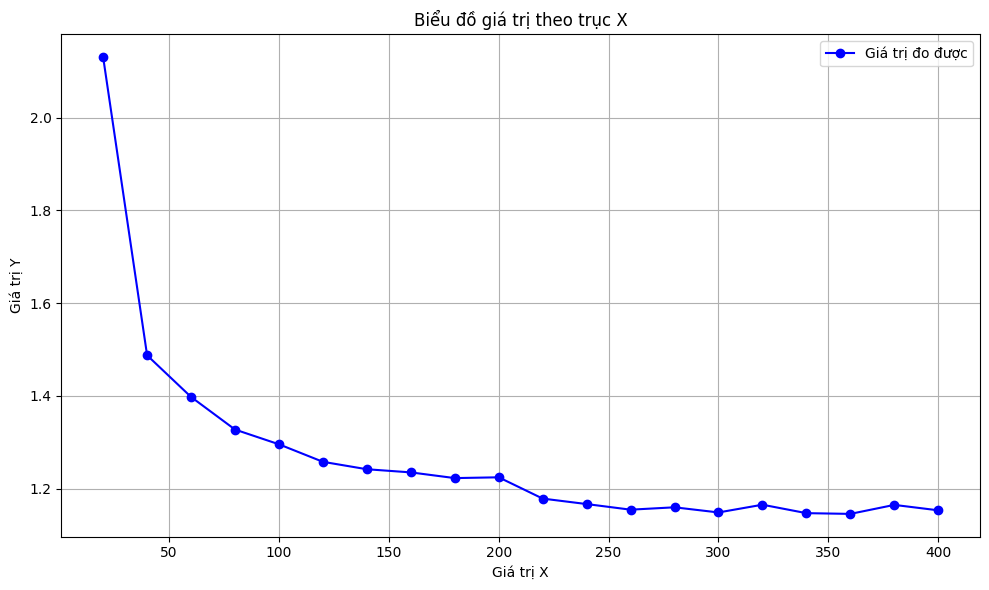

In [31]:
import matplotlib.pyplot as plt

# Dữ liệu: cặp (x, y)
x = [
    20, 40, 60, 80, 100, 120, 140, 160, 180, 200,
    220, 240, 260, 280, 300, 320, 340, 360, 380, 400
]

y = [
    2.130400, 1.487500, 1.397700, 1.327400, 1.295600,
    1.257800, 1.241800, 1.235000, 1.222700, 1.224400,
    1.178500, 1.166700, 1.154600, 1.159700, 1.148600,
    1.165300, 1.147100, 1.145500, 1.164900, 1.153200
]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Giá trị đo được')

# Thêm tiêu đề và nhãn trục
plt.title('Biểu đồ giá trị theo trục X')
plt.xlabel('Giá trị X')
plt.ylabel('Giá trị Y')

# Hiển thị lưới và chú thích
plt.grid(True)
plt.legend()
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


In [23]:
trainer.save_model()

In [24]:
model, tokenizer = FastLanguageModel.from_pretrained(
"/content/drive/MyDrive/checkpoint/llama3-1b-multi-conversation",
max_seq_length=2048,
load_in_4bit=True,
dtype=torch.bfloat16,
)

==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [28]:
model.push_to_hub_merged(
"hoa12356/Llama-3.2-1B-Instruct-Chat-sft-hoa",
commit_message="Merge weights to push to hub",
)

tokenizer.push_to_hub(
"hoa12356/Llama-3.2-1B-Instruct-Chat-sft-hoa",
commit_message="Push tokenizer to hub",
)

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.07 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 16/16 [00:00<00:00, 42.18it/s]



Unsloth: Saving Llama-3.2-1B-Instruct-Chat-sft-hoa/pytorch_model.bin...


pytorch_model.bin:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/hoa12356/Llama-3.2-1B-Instruct-Chat-sft-hoa


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [ ]:
from transformers import GenerationConfig
import torch

generation_config = GenerationConfig(
    max_new_tokens=128,
    temperature=1.0,
    do_sample=False,
    num_return_sequences=1,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    repetition_penalty=1.3
)

prompt = [
    {"role": "system", "content": (
        "Bạn là một trợ lý AI thân thiện, "
        "hãy trả lời bằng tiếng Việt."
    )},

    {"role": "user", "content": (
        "Hãy chỉnh sửa câu này để ngắn gọn hơn mà không mất đi ý nghĩa: "
        "\"Trận đấu là một thất bại nặng nề "
        "mặc dù thực tế là cả đội đã tập luyện trong nhiều tuần.\""
    )},

    {"role": "assistant", "content": (
        "Nhiều tuần huấn luyện của đội đã dẫn đến một thất bại nặng nề."
    )},

    {"role": "user", "content": (
        "Bạn có thể đề xuất một số chiến lược mà "
        "nhóm có thể sử dụng để cải thiện hiệu suất "
        "của họ trong trận đấu tiếp theo không?"
    )}
]


chat_text = tokenizer.apply_chat_template(
    prompt,
    add_generation_prompt=True,
    tokenize=False
)

# Token hóa
inputs = tokenizer(
    chat_text,
    return_tensors="pt"
).to("cuda:0")

# Sinh văn bản
with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        generation_config=generation_config,
    )


output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)


if "assistant\n" in output_text:
    answer = output_text.split("assistant\n")[-1].strip()
else:
    answer = output_text.strip()


print("Assistant reply:", answer)


Assistant reply: Chắc chắn! Dưới đây là một vài mẹo về cách các nhà tổ chức và cầu thủ cùng nhau tạo ra môi trường hỗ trợ tốt cho sự tiến bộ của mình đối với trò chơi sắp tới: - Đảm bảo rằng tất cả thành viên đều hiểu mục tiêu chung cũng như tầm quan trọng của việc học hỏi từ những sai lầm trước đó. Điều này sẽ giúp mọi người cảm thấy được kết nối và sẵn sàng làm việc chăm chỉ khi đạt được điều gì đó mới mẻ. - Tạo bầu không khí tích cực xung quanh phòng thi đấu hoặc sân vận động thông qua âm thanh vui tươi, ánh sáng
